In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.special import erf
import pandas as pd

from absl import app, flags

from iflow.integration import integrator
from iflow.integration import couplings

tfd = tfp.distributions  # pylint: disable=invalid-name
tfb = tfp.bijectors  # pylint: disable=invalid-name
tf.keras.backend.set_floatx('float64')

In [2]:
def prepare_mother_list(filepath, make_plot=True):
    # read and add column names
    data = pd.read_csv(filepath, header=None, sep=' ')
    data.columns = ['Event', 'mJJ', 'mJ1', 'tau21J1', 'dmJ', 'tau21J2']
    data.set_index('Event', inplace=True)
    
    # remove nans and 0s, sort
    data = data[~np.any(np.isnan(data) | (data==0), axis=1)]
    data.sort_values(by='mJJ', inplace=True)
    
    print('read array of shape {}'.format(data.shape))
    print(data.head())
    if make_plot:
        div, mod = divmod(len(data.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(data.columns):
            axs[divmod(i, 3)].set_title(feature)
            axs[divmod(i, 3)].hist(data.iloc[:, i], density=True)
        if mod != 0:
            for i in range(mod, 3):
                axs[rows-1, i].remove()        
        plt.tight_layout()
        plt.show()

    return data

def prepare_data_train_signal(M,deltaM,list_by_minv):
    # pick a window
    listcp = np.copy(list_by_minv)
    listcp[:,0]=np.where(listcp[:,0]>(M+deltaM),0,listcp[:,0])
    listcp[:,0]=np.where(listcp[:,0]<(M-deltaM),0,listcp[:,0])
    mask = np.any (np.equal(listcp, 0), axis=1)
    sublist=listcp[~mask]
    
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    
    return data_train[:,1:5],sublist[:,0]

def prepare_data_train_bkg(list_by_minv):
    
    sublist=np.copy(list_by_minv)   
    # make it a unit hypercube
    minimum=np.amin(list_by_minv,axis=0,keepdims=True)
    maximum=np.amax(list_by_minv,axis=0,keepdims=True)
    data_train=(sublist-minimum)*(1.0/(maximum-minimum))
    data_train = tf.where(data_train > 1e-16, data_train, data_train+1e-16)
    data_train = tf.where(data_train <1.0, data_train, 1.0-1e-16)
    return data_train[:,1:5]

def prepare_data_train(M,deltaM,list_by_minv):
    window = (list_by_minv.mJJ >= (M-3*deltaM)) & (list_by_minv.mJJ <= (M+3*deltaM))
    window = list_by_minv[window]
    SR = (window.mJJ > (M-deltaM)) & (window.mJJ < (M+deltaM))
    SR_masses = window[SR].mJJ.values

    #put the data on a unit hypercube and remove the edges
    hypercubemargin = 1e-10
    minmax = list_by_minv.agg(['min', 'max'])
    # exact hypercube
    window = (window - minmax.loc['min'])/(minmax.loc['max'] - minmax.loc['min'])
    # shrink to margin
    window = window * (1-2*hypercubemargin) + hypercubemargin
    
    SB = window[~SR].copy()
    SR = window[SR].copy()
    return tf.convert_to_tensor(SB.values), tf.convert_to_tensor(SR.values), SR_masses

def combine_sig_bkg(sig, bkg, make_plot=True):
    sig['signal'] = True
    bkg['signal'] = False
    
    combined = pd.concat([sig, bkg])
    if make_plot:
        div, mod = divmod(len(combined.columns), 3)
        if mod == 0:
            rows = div
        else:
            rows = 1 + div
        fig, axs = plt.subplots(rows, 3, figsize=(4*3, 4 * rows))
        for i, feature in enumerate(combined.columns):
            axs[divmod(i, 3)].set_title(feature)
            if combined.iloc[:, i].dtype == 'bool':
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [len(combined[combined.signal]), 0],
                                      label='signal')
                axs[divmod(i, 3)].bar(['True', 'False'],
                                      [0, len(combined[~combined.signal])],
                                      label='background')
            else:
                axs[divmod(i, 3)].hist(combined[combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='signal')
                axs[divmod(i, 3)].hist(combined[~combined.signal].iloc[:, i],
                                       density=False, histtype='barstacked',
                                       label='background')
            if i == 0:
                axs[divmod(i, 3)].legend()
        plt.tight_layout()
        plt.show()
    
    return combined

In [3]:
def build(in_features, out_features, options):
    " Build the NN. """
    del options

    invals = tf.keras.layers.Input(in_features, dtype=tf.float64)
    hidden = tf.keras.layers.Dense(32, activation='relu')(invals)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    hidden = tf.keras.layers.BatchNormalization(axis=-1)(hidden)
    hidden = tf.keras.layers.Dense(32, activation='relu')(hidden)
    outputs = tf.keras.layers.Dense(out_features)(hidden)
    model = tf.keras.models.Model(invals, outputs)
    model.summary()
    return model

In [4]:
def mask_flip(mask):
    """ Interchange 0 <-> 1 in the mask. """
    return 1-mask


def binary_list(inval, length):
    """ Convert x into a binary list of length l. """
    return np.array([int(i) for i in np.binary_repr(inval, length)])


def binary_masks(ndims):
    """ Create binary masks for to account for symmetries. """
    n_masks = int(np.ceil(np.log2(ndims)))
    sub_masks = np.transpose(np.array(
        [binary_list(i, n_masks)
         for i in range(ndims)]))[::-1]
    flip_masks = mask_flip(sub_masks)

    # Combine masks
    masks = np.empty((2*n_masks, ndims))
    masks[0::2] = flip_masks
    masks[1::2] = sub_masks

    return masks

In [5]:
print(binary_masks(4))
np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))

[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]]


array([[0., 1., 0., 1., 0.],
       [0., 0., 1., 0., 1.],
       [0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 1.]])

In [6]:
def build_iflow(ndims,lr):
    masks = np.pad(binary_masks(4),((0,0),(1,0)),'constant',constant_values=(0,0))
    bijector=[]
    for mask in masks:
        bijector.append(couplings.PiecewiseRationalQuadratic(mask,build,num_bins=16,blob=None,options=None))
    
    bijector=tfb.Chain(list(reversed(bijector)))
    low = np.zeros(ndims, dtype=np.float64)
    high = np.ones(ndims, dtype=np.float64)
    dist = tfd.Uniform(low=low, high=high)
    dist = tfd.Independent(distribution=dist,reinterpreted_batch_ndims=1)
    dist = tfd.TransformedDistribution(distribution=dist,bijector=bijector)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(lr, decay_steps=100, decay_rate=0.5)
    optimizer = tf.keras.optimizers.Adam(lr, clipnorm=10.0#, amsgrad=True
                                        )
    return dist, optimizer

In [7]:
@tf.function
def train_one_step(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no2(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

@tf.function
def train_one_step_no3(dist,optimizer,samples):
    #samples=data_train[epoch*nsamples:(epoch+1)*nsamples,:]
    with tf.GradientTape() as tape:
        test = dist.prob(samples)
        #print(test)
        #logq = dist.log_prob(samples)
        #mean, var = tf.nn.moments(x=true/test, axes=[0])
        #true = tf.stop_gradient(true/mean)
        logq = tf.where(test > 1e-16, tf.math.log(test),tf.math.log(test+1e-16))
        #print(logq)
        loss = - tf.reduce_mean(logq)
        
    grads = tape.gradient(loss, dist.trainable_variables)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    return loss

In [8]:
def save_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.save_weights(
                './models/model_layer_{:02d}'.format(j))

def load_weights(dist):
    for j, bijector in enumerate(dist.bijector.bijectors):
        bijector.transform_net.load_weights(
                './models/model_layer_{:02d}'.format(j))
    print("Model loaded successfully")

In [9]:
def train_iflow(list_by_minv,M=3800, deltaM=100, issig=True, batchsize=200,lr=1e-3,epochs=10):
    
    bkg, sig, invM = prepare_data_train(M,deltaM,list_by_minv)
   
    if issig:
        data_train = sig
    else:
        data_train = bkg
        
    (totalpts, ndims) = np.shape(data_train)
    print(totalpts)
    
    dist, optimizer = build_iflow(ndims,lr) #ignore the dimension of invM_{j1,j2}
       
    batches = int(totalpts/batchsize)
    print(batches)
    
    #try:
        #load_weights(dist)
    #except tf.errors.InvalidArgumentError:
    for epoch in range(epochs+1):
        data_train=tf.random.shuffle(data_train)
        for batch in range(batches+1):
            samples=data_train[batch*batchsize:(batch+1)*batchsize,:]
                #print(samples)
            try:
                loss = train_one_step(dist,optimizer,samples)
            except:
                try:
                    loss = train_one_step_no2(dist, optimizer, samples)
                except:
                    loss = train_one_step_no3(dist, optimizer, samples)
            if batch % 10 ==0:
                print('Batch: {:3d} Loss = {:8e}'.format(batch, loss))
        if epoch % 1 == 0:
            print('Epoch: {:3d} Loss = {:8e}'.format(epoch, loss))
    save_weights(dist)
    return dist

Import Data

read array of shape (999668, 5)
            mJJ       mJ1   tau21J1       dmJ   tau21J2
Event                                                  
450885  1132.28  256.4420  0.584751  122.0150  0.721372
900271  1344.41  136.4530  0.656294   45.9379  0.778359
606527  1356.00  221.5270  0.348195   17.9149  0.791087
618345  1359.23   66.5476  0.586281  100.3800  0.413897
602321  1369.24  153.4330  0.509714   16.0895  0.653790


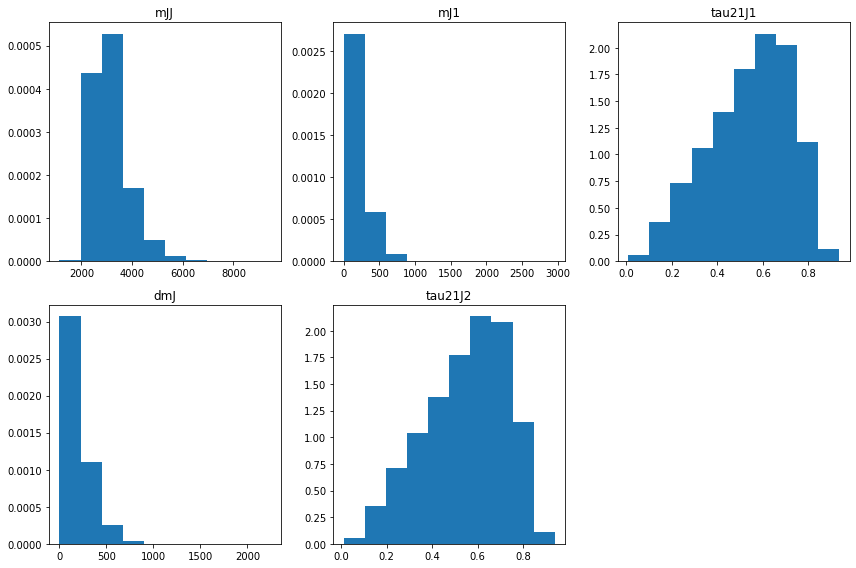

read array of shape (99948, 5)
           mJJ       mJ1   tau21J1       dmJ   tau21J2
Event                                                 
61569  1640.86  231.3330  0.468651   61.7481  0.801618
12978  1700.06  104.3390  0.156207   95.4028  0.565405
845    1703.78  116.1400  0.318631   55.2056  0.430425
69763  1718.81  113.0020  0.467825  102.3100  0.778852
821    1748.70   94.0819  0.437161   39.1778  0.657479


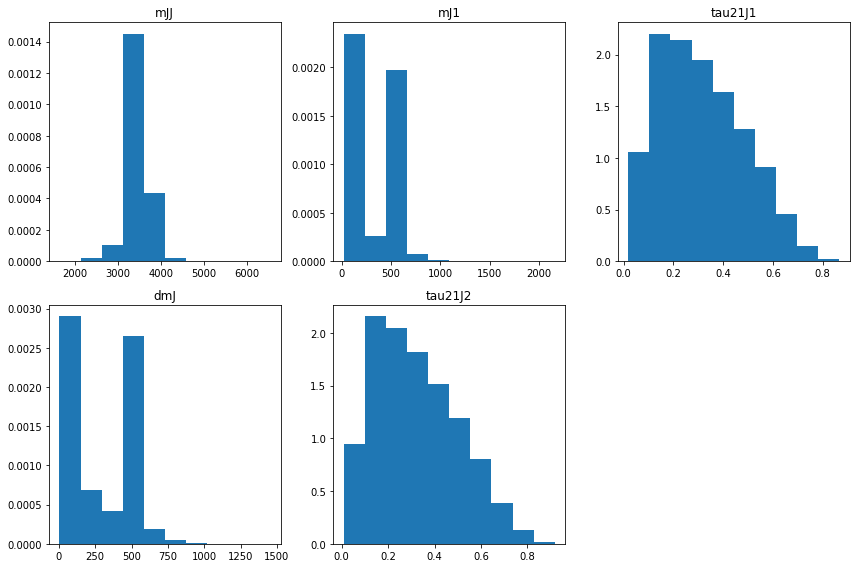

In [10]:
bkgname="rndbkgout.txt"
signame="rndsigout.txt"
bkglist=prepare_mother_list(bkgname)
siglist=prepare_mother_list(signame)

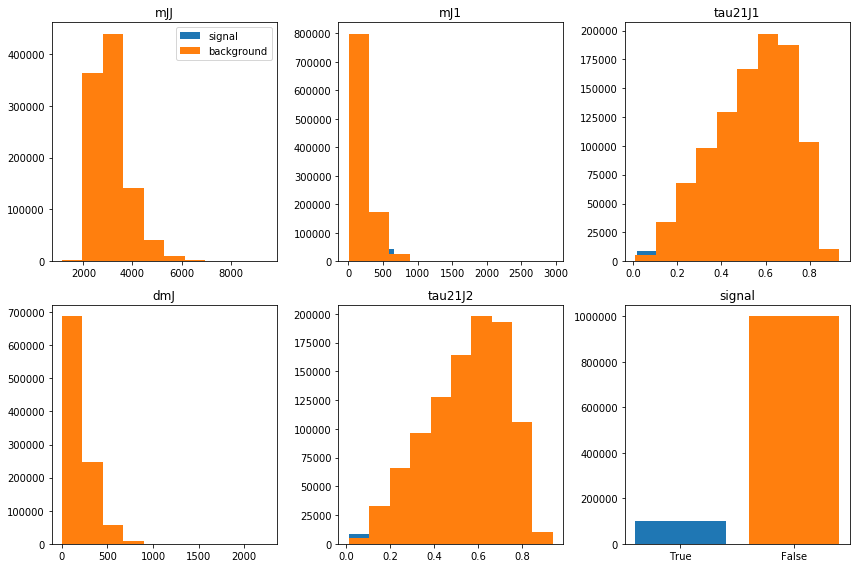

In [35]:
combined = combine_sig_bkg(siglist, bkglist)

Train on Signal Data

In [12]:
sigdist =train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=100,
                     issig=True, batchsize=256,lr=1e-3,epochs=50)

119476
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense (Dense)                (None, 32)                128       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)               

Epoch:   0 Loss = -4.281144e+00
Batch:   0 Loss = -4.395531e+00
Batch:  10 Loss = -4.135802e+00
Batch:  20 Loss = -4.280890e+00
Batch:  30 Loss = -4.296653e+00
Batch:  40 Loss = -4.318327e+00
Batch:  50 Loss = -4.266244e+00
Batch:  60 Loss = -4.433117e+00
Batch:  70 Loss = -4.371458e+00
Batch:  80 Loss = -4.000986e+00
Batch:  90 Loss = -4.220967e+00
Batch: 100 Loss = -4.289366e+00
Batch: 110 Loss = -4.176718e+00
Batch: 120 Loss = -4.292624e+00
Batch: 130 Loss = -4.271642e+00
Batch: 140 Loss = -4.302350e+00
Batch: 150 Loss = -4.274912e+00
Batch: 160 Loss = -4.200893e+00
Batch: 170 Loss = -4.555253e+00
Batch: 180 Loss = -4.231109e+00
Batch: 190 Loss = -4.331573e+00
Batch: 200 Loss = -4.377000e+00
Batch: 210 Loss = -4.334235e+00
Batch: 220 Loss = -4.169815e+00
Batch: 230 Loss = -4.189357e+00
Batch: 240 Loss = -4.344142e+00
Batch: 250 Loss = -4.247943e+00
Batch: 260 Loss = -4.439497e+00
Batch: 270 Loss = -4.470487e+00
Batch: 280 Loss = -4.130625e+00
Batch: 290 Loss = -4.396761e+00
Batch: 3

Batch: 160 Loss = -4.577787e+00
Batch: 170 Loss = -4.453348e+00
Batch: 180 Loss = -4.493157e+00
Batch: 190 Loss = -4.562539e+00
Batch: 200 Loss = -4.551766e+00
Batch: 210 Loss = -4.549008e+00
Batch: 220 Loss = -4.532552e+00
Batch: 230 Loss = -4.213191e+00
Batch: 240 Loss = -4.446401e+00
Batch: 250 Loss = -4.504259e+00
Batch: 260 Loss = -4.377258e+00
Batch: 270 Loss = -4.648664e+00
Batch: 280 Loss = -4.559146e+00
Batch: 290 Loss = -4.535377e+00
Batch: 300 Loss = -4.575782e+00
Batch: 310 Loss = -4.436509e+00
Batch: 320 Loss = -4.586866e+00
Batch: 330 Loss = -4.489716e+00
Batch: 340 Loss = -4.513078e+00
Batch: 350 Loss = -4.582548e+00
Batch: 360 Loss = -4.569431e+00
Batch: 370 Loss = -4.256383e+00
Batch: 380 Loss = -4.597923e+00
Batch: 390 Loss = -4.463707e+00
Batch: 400 Loss = -4.331973e+00
Batch: 410 Loss = -4.468403e+00
Batch: 420 Loss = -4.574770e+00
Batch: 430 Loss = -4.339623e+00
Batch: 440 Loss = -4.519940e+00
Batch: 450 Loss = -4.492312e+00
Batch: 460 Loss = -4.829952e+00
Epoch:  

Batch: 330 Loss = -4.507538e+00
Batch: 340 Loss = -4.608493e+00
Batch: 350 Loss = -4.633056e+00
Batch: 360 Loss = -4.411280e+00
Batch: 370 Loss = -4.578325e+00
Batch: 380 Loss = -4.566431e+00
Batch: 390 Loss = -4.608219e+00
Batch: 400 Loss = -4.519783e+00
Batch: 410 Loss = -4.296127e+00
Batch: 420 Loss = -4.517566e+00
Batch: 430 Loss = -4.405331e+00
Batch: 440 Loss = -4.510302e+00
Batch: 450 Loss = -4.439228e+00
Batch: 460 Loss = -4.494895e+00
Epoch:  11 Loss = -4.435256e+00
Batch:   0 Loss = -4.372180e+00
Batch:  10 Loss = -4.635692e+00
Batch:  20 Loss = -4.555971e+00
Batch:  30 Loss = -4.537369e+00
Batch:  40 Loss = -4.362695e+00
Batch:  50 Loss = -4.445312e+00
Batch:  60 Loss = -4.417495e+00
Batch:  70 Loss = -4.453700e+00
Batch:  80 Loss = -4.324321e+00
Batch:  90 Loss = -4.553678e+00
Batch: 100 Loss = -4.484113e+00
Batch: 110 Loss = -4.412592e+00
Batch: 120 Loss = -4.374693e+00
Batch: 130 Loss = -4.481806e+00
Batch: 140 Loss = -4.582045e+00
Batch: 150 Loss = -4.633293e+00
Batch: 1

Batch:  20 Loss = -4.447858e+00
Batch:  30 Loss = -4.538722e+00
Batch:  40 Loss = -4.388832e+00
Batch:  50 Loss = -4.473630e+00
Batch:  60 Loss = -4.683222e+00
Batch:  70 Loss = -4.256462e+00
Batch:  80 Loss = -4.672595e+00
Batch:  90 Loss = -4.385659e+00
Batch: 100 Loss = -4.392396e+00
Batch: 110 Loss = -4.612721e+00
Batch: 120 Loss = -4.432619e+00
Batch: 130 Loss = -4.486812e+00
Batch: 140 Loss = -4.421726e+00
Batch: 150 Loss = -4.440637e+00
Batch: 160 Loss = -4.421940e+00
Batch: 170 Loss = -4.319691e+00
Batch: 180 Loss = -4.436858e+00
Batch: 190 Loss = -4.347117e+00
Batch: 200 Loss = -4.669382e+00
Batch: 210 Loss = -4.558297e+00
Batch: 220 Loss = -4.482275e+00
Batch: 230 Loss = -4.351980e+00
Batch: 240 Loss = -4.542283e+00
Batch: 250 Loss = -4.316818e+00
Batch: 260 Loss = -4.494562e+00
Batch: 270 Loss = -4.404103e+00
Batch: 280 Loss = -4.576237e+00
Batch: 290 Loss = -4.373939e+00
Batch: 300 Loss = -4.365483e+00
Batch: 310 Loss = -4.514706e+00
Batch: 320 Loss = -4.583671e+00
Batch: 3

Batch: 190 Loss = -4.449646e+00
Batch: 200 Loss = -4.516681e+00
Batch: 210 Loss = -4.728991e+00
Batch: 220 Loss = -4.388958e+00
Batch: 230 Loss = -4.462629e+00
Batch: 240 Loss = -4.367372e+00
Batch: 250 Loss = -4.518371e+00
Batch: 260 Loss = -4.453504e+00
Batch: 270 Loss = -4.326062e+00
Batch: 280 Loss = -4.459291e+00
Batch: 290 Loss = -4.508599e+00
Batch: 300 Loss = -4.368009e+00
Batch: 310 Loss = -4.385948e+00
Batch: 320 Loss = -4.417475e+00
Batch: 330 Loss = -4.324510e+00
Batch: 340 Loss = -4.402041e+00
Batch: 350 Loss = -4.501863e+00
Batch: 360 Loss = -4.604412e+00
Batch: 370 Loss = -4.638699e+00
Batch: 380 Loss = -4.405094e+00
Batch: 390 Loss = -4.415668e+00
Batch: 400 Loss = -4.435678e+00
Batch: 410 Loss = -4.599023e+00
Batch: 420 Loss = -4.351480e+00
Batch: 430 Loss = -4.557620e+00
Batch: 440 Loss = -4.487245e+00
Batch: 450 Loss = -4.487612e+00
Batch: 460 Loss = -4.641404e+00
Epoch:  22 Loss = -4.433778e+00
Batch:   0 Loss = -4.469105e+00
Batch:  10 Loss = -4.647237e+00
Batch:  

Batch: 360 Loss = -4.432970e+00
Batch: 370 Loss = -4.529034e+00
Batch: 380 Loss = -4.451788e+00
Batch: 390 Loss = -4.540706e+00
Batch: 400 Loss = -4.464989e+00
Batch: 410 Loss = -4.508149e+00
Batch: 420 Loss = -4.582079e+00
Batch: 430 Loss = -4.492445e+00
Batch: 440 Loss = -4.505414e+00
Batch: 450 Loss = -4.545672e+00
Batch: 460 Loss = -4.526001e+00
Epoch:  27 Loss = -4.414852e+00
Batch:   0 Loss = -4.346717e+00
Batch:  10 Loss = -4.471011e+00
Batch:  20 Loss = -4.260350e+00
Batch:  30 Loss = -4.612953e+00
Batch:  40 Loss = -4.411926e+00
Batch:  50 Loss = -4.592847e+00
Batch:  60 Loss = -4.484069e+00
Batch:  70 Loss = -4.610063e+00
Batch:  80 Loss = -4.651524e+00
Batch:  90 Loss = -4.505474e+00
Batch: 100 Loss = -4.595425e+00
Batch: 110 Loss = -4.562446e+00
Batch: 120 Loss = -4.487719e+00
Batch: 130 Loss = -4.489441e+00
Batch: 140 Loss = -4.686742e+00
Batch: 150 Loss = -4.518127e+00
Batch: 160 Loss = -4.475300e+00
Batch: 170 Loss = -4.550734e+00
Batch: 180 Loss = -4.609172e+00
Batch: 1

Batch:  50 Loss = -4.571101e+00
Batch:  60 Loss = -4.445912e+00
Batch:  70 Loss = -4.475136e+00
Batch:  80 Loss = -4.572331e+00
Batch:  90 Loss = -4.643920e+00
Batch: 100 Loss = -4.588675e+00
Batch: 110 Loss = -4.407075e+00
Batch: 120 Loss = -4.663058e+00
Batch: 130 Loss = -4.610198e+00
Batch: 140 Loss = -4.407720e+00
Batch: 150 Loss = -4.481995e+00
Batch: 160 Loss = -4.448577e+00
Batch: 170 Loss = -4.405213e+00
Batch: 180 Loss = -4.256930e+00
Batch: 190 Loss = -4.487737e+00
Batch: 200 Loss = -4.570728e+00
Batch: 210 Loss = -4.419899e+00
Batch: 220 Loss = -4.732085e+00
Batch: 230 Loss = -4.414605e+00
Batch: 240 Loss = -4.587378e+00
Batch: 250 Loss = -4.351987e+00
Batch: 260 Loss = -4.378210e+00
Batch: 270 Loss = -4.796062e+00
Batch: 280 Loss = -4.382539e+00
Batch: 290 Loss = -4.568929e+00
Batch: 300 Loss = -4.511120e+00
Batch: 310 Loss = -4.754562e+00
Batch: 320 Loss = -4.539341e+00
Batch: 330 Loss = -4.601594e+00
Batch: 340 Loss = -4.453303e+00
Batch: 350 Loss = -4.423392e+00
Batch: 3

Batch: 220 Loss = -4.606130e+00
Batch: 230 Loss = -4.560163e+00
Batch: 240 Loss = -4.500329e+00
Batch: 250 Loss = -4.505562e+00
Batch: 260 Loss = -4.742118e+00
Batch: 270 Loss = -4.554979e+00
Batch: 280 Loss = -4.507342e+00
Batch: 290 Loss = -4.486239e+00
Batch: 300 Loss = -4.525967e+00
Batch: 310 Loss = -4.547740e+00
Batch: 320 Loss = -4.652701e+00
Batch: 330 Loss = -4.510019e+00
Batch: 340 Loss = -4.655641e+00
Batch: 350 Loss = -4.535766e+00
Batch: 360 Loss = -4.411998e+00
Batch: 370 Loss = -4.331971e+00
Batch: 380 Loss = -4.641771e+00
Batch: 390 Loss = -4.462169e+00
Batch: 400 Loss = -4.589821e+00
Batch: 410 Loss = -4.553223e+00
Batch: 420 Loss = -4.718646e+00
Batch: 430 Loss = -4.507470e+00
Batch: 440 Loss = -4.586246e+00
Batch: 450 Loss = -4.383494e+00
Batch: 460 Loss = -4.578326e+00
Epoch:  38 Loss = -4.479719e+00
Batch:   0 Loss = -4.537525e+00
Batch:  10 Loss = -4.470818e+00
Batch:  20 Loss = -4.509409e+00
Batch:  30 Loss = -4.459066e+00
Batch:  40 Loss = -4.564680e+00
Batch:  

Batch: 390 Loss = -4.305812e+00
Batch: 400 Loss = -4.525066e+00
Batch: 410 Loss = -4.419251e+00
Batch: 420 Loss = -4.557701e+00
Batch: 430 Loss = -4.533752e+00
Batch: 440 Loss = -4.319944e+00
Batch: 450 Loss = -4.569038e+00
Batch: 460 Loss = -4.371931e+00
Epoch:  43 Loss = -4.344213e+00
Batch:   0 Loss = -4.673568e+00
Batch:  10 Loss = -4.580420e+00
Batch:  20 Loss = -4.516219e+00
Batch:  30 Loss = -4.562605e+00
Batch:  40 Loss = -4.539851e+00
Batch:  50 Loss = -4.664257e+00
Batch:  60 Loss = -4.467403e+00
Batch:  70 Loss = -4.688139e+00
Batch:  80 Loss = -4.496325e+00
Batch:  90 Loss = -4.576480e+00
Batch: 100 Loss = -4.566074e+00
Batch: 110 Loss = -4.657618e+00
Batch: 120 Loss = -4.465170e+00
Batch: 130 Loss = -4.449218e+00
Batch: 140 Loss = -4.330920e+00
Batch: 150 Loss = -4.494837e+00
Batch: 160 Loss = -4.657633e+00
Batch: 170 Loss = -4.408303e+00
Batch: 180 Loss = -4.474313e+00
Batch: 190 Loss = -4.536409e+00
Batch: 200 Loss = -4.639928e+00
Batch: 210 Loss = -4.578389e+00
Batch: 2

Batch:  80 Loss = -4.586480e+00
Batch:  90 Loss = -4.577927e+00
Batch: 100 Loss = -4.758907e+00
Batch: 110 Loss = -4.294954e+00
Batch: 120 Loss = -4.396070e+00
Batch: 130 Loss = -4.546861e+00
Batch: 140 Loss = -4.670405e+00
Batch: 150 Loss = -4.576284e+00
Batch: 160 Loss = -4.501590e+00
Batch: 170 Loss = -4.579546e+00
Batch: 180 Loss = -4.567078e+00
Batch: 190 Loss = -4.410731e+00
Batch: 200 Loss = -4.349067e+00
Batch: 210 Loss = -4.597701e+00
Batch: 220 Loss = -4.470041e+00
Batch: 230 Loss = -4.565164e+00
Batch: 240 Loss = -4.370491e+00
Batch: 250 Loss = -4.441733e+00
Batch: 260 Loss = -4.269287e+00
Batch: 270 Loss = -4.597029e+00
Batch: 280 Loss = -4.506037e+00
Batch: 290 Loss = -4.498583e+00
Batch: 300 Loss = -4.448623e+00
Batch: 310 Loss = -4.538369e+00
Batch: 320 Loss = -4.537029e+00
Batch: 330 Loss = -4.448287e+00
Batch: 340 Loss = -4.676375e+00
Batch: 350 Loss = -4.488422e+00
Batch: 360 Loss = -4.603004e+00
Batch: 370 Loss = -4.546957e+00
Batch: 380 Loss = -4.552881e+00
Batch: 3

Train on Background Data

In [13]:
bkgdist = train_iflow(combined.drop(columns='signal') ,M=3500, deltaM=100,
                      issig=False, batchsize=256,lr=1e-3,epochs=50) #do not use learning rate schedule

182221
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 3)]               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                128       
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_26 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_27 (Dense)             (None, 32)             

Batch: 470 Loss = -3.918022e+00
Batch: 480 Loss = -3.961709e+00
Batch: 490 Loss = -3.883596e+00
Batch: 500 Loss = -3.938682e+00
Batch: 510 Loss = -3.989943e+00
Batch: 520 Loss = -3.935144e+00
Batch: 530 Loss = -3.908027e+00
Batch: 540 Loss = -3.936143e+00
Batch: 550 Loss = -3.994982e+00
Batch: 560 Loss = -3.800472e+00
Batch: 570 Loss = -4.078452e+00
Batch: 580 Loss = -4.037801e+00
Batch: 590 Loss = -3.906115e+00
Batch: 600 Loss = -3.938758e+00
Batch: 610 Loss = -3.972884e+00
Batch: 620 Loss = -3.958007e+00
Batch: 630 Loss = -3.968787e+00
Batch: 640 Loss = -4.012926e+00
Batch: 650 Loss = -4.032897e+00
Batch: 660 Loss = -3.965563e+00
Batch: 670 Loss = -4.025973e+00
Batch: 680 Loss = -3.988145e+00
Batch: 690 Loss = -4.038994e+00
Batch: 700 Loss = -4.014826e+00
Batch: 710 Loss = -4.031249e+00
Epoch:   0 Loss = -4.070908e+00
Batch:   0 Loss = -4.128645e+00
Batch:  10 Loss = -3.806582e+00
Batch:  20 Loss = -3.845627e+00
Batch:  30 Loss = -3.906559e+00
Batch:  40 Loss = -4.044141e+00
Batch:  

Batch: 120 Loss = -4.034483e+00
Batch: 130 Loss = -4.120039e+00
Batch: 140 Loss = -4.084948e+00
Batch: 150 Loss = -3.926213e+00
Batch: 160 Loss = -4.016946e+00
Batch: 170 Loss = -4.144046e+00
Batch: 180 Loss = -3.918061e+00
Batch: 190 Loss = -4.015465e+00
Batch: 200 Loss = -4.031834e+00
Batch: 210 Loss = -4.073637e+00
Batch: 220 Loss = -3.956203e+00
Batch: 230 Loss = -3.958762e+00
Batch: 240 Loss = -4.009186e+00
Batch: 250 Loss = -4.036877e+00
Batch: 260 Loss = -3.887555e+00
Batch: 270 Loss = -4.090058e+00
Batch: 280 Loss = -4.077065e+00
Batch: 290 Loss = -4.047920e+00
Batch: 300 Loss = -4.049811e+00
Batch: 310 Loss = -3.987589e+00
Batch: 320 Loss = -4.131032e+00
Batch: 330 Loss = -4.075447e+00
Batch: 340 Loss = -3.997899e+00
Batch: 350 Loss = -4.118506e+00
Batch: 360 Loss = -3.930558e+00
Batch: 370 Loss = -4.039535e+00
Batch: 380 Loss = -4.108152e+00
Batch: 390 Loss = -4.104180e+00
Batch: 400 Loss = -4.168108e+00
Batch: 410 Loss = -4.127287e+00
Batch: 420 Loss = -4.098668e+00
Batch: 4

Batch: 500 Loss = -4.015941e+00
Batch: 510 Loss = -4.143953e+00
Batch: 520 Loss = -4.088811e+00
Batch: 530 Loss = -4.177509e+00
Batch: 540 Loss = -4.001463e+00
Batch: 550 Loss = -4.403628e+00
Batch: 560 Loss = -3.977585e+00
Batch: 570 Loss = -4.093570e+00
Batch: 580 Loss = -4.147428e+00
Batch: 590 Loss = -4.178934e+00
Batch: 600 Loss = -4.127642e+00
Batch: 610 Loss = -3.970344e+00
Batch: 620 Loss = -4.116941e+00
Batch: 630 Loss = -4.243671e+00
Batch: 640 Loss = -4.180166e+00
Batch: 650 Loss = -4.127487e+00
Batch: 660 Loss = -3.993258e+00
Batch: 670 Loss = -4.039671e+00
Batch: 680 Loss = -4.212262e+00
Batch: 690 Loss = -3.992740e+00
Batch: 700 Loss = -4.135153e+00
Batch: 710 Loss = -4.039376e+00
Epoch:   7 Loss = -4.146749e+00
Batch:   0 Loss = -4.100388e+00
Batch:  10 Loss = -4.074318e+00
Batch:  20 Loss = -4.086313e+00
Batch:  30 Loss = -4.020851e+00
Batch:  40 Loss = -4.058964e+00
Batch:  50 Loss = -3.990046e+00
Batch:  60 Loss = -4.049916e+00
Batch:  70 Loss = -4.020868e+00
Batch:  

Batch: 150 Loss = -4.156871e+00
Batch: 160 Loss = -4.128563e+00
Batch: 170 Loss = -3.913384e+00
Batch: 180 Loss = -4.136201e+00
Batch: 190 Loss = -4.230724e+00
Batch: 200 Loss = -4.123935e+00
Batch: 210 Loss = -4.173289e+00
Batch: 220 Loss = -4.096936e+00
Batch: 230 Loss = -4.056592e+00
Batch: 240 Loss = -4.105741e+00
Batch: 250 Loss = -4.108573e+00
Batch: 260 Loss = -3.976495e+00
Batch: 270 Loss = -4.156823e+00
Batch: 280 Loss = -4.174656e+00
Batch: 290 Loss = -4.168785e+00
Batch: 300 Loss = -4.053509e+00
Batch: 310 Loss = -4.153254e+00
Batch: 320 Loss = -4.015207e+00
Batch: 330 Loss = -4.139241e+00
Batch: 340 Loss = -4.243750e+00
Batch: 350 Loss = -4.201750e+00
Batch: 360 Loss = -4.083326e+00
Batch: 370 Loss = -4.118266e+00
Batch: 380 Loss = -4.246256e+00
Batch: 390 Loss = -4.006936e+00
Batch: 400 Loss = -4.006892e+00
Batch: 410 Loss = -4.233759e+00
Batch: 420 Loss = -3.968998e+00
Batch: 430 Loss = -4.132596e+00
Batch: 440 Loss = -4.006176e+00
Batch: 450 Loss = -4.032490e+00
Batch: 4

Batch: 530 Loss = -4.043545e+00
Batch: 540 Loss = -4.152467e+00
Batch: 550 Loss = -4.002007e+00
Batch: 560 Loss = -4.259152e+00
Batch: 570 Loss = -4.261651e+00
Batch: 580 Loss = -4.153336e+00
Batch: 590 Loss = -4.188353e+00
Batch: 600 Loss = -4.100106e+00
Batch: 610 Loss = -4.020701e+00
Batch: 620 Loss = -4.056147e+00
Batch: 630 Loss = -4.037415e+00
Batch: 640 Loss = -4.061481e+00
Batch: 650 Loss = -4.203641e+00
Batch: 660 Loss = -4.135318e+00
Batch: 670 Loss = -4.058254e+00
Batch: 680 Loss = -3.968128e+00
Batch: 690 Loss = -4.290311e+00
Batch: 700 Loss = -4.131717e+00
Batch: 710 Loss = -4.011007e+00
Epoch:  14 Loss = -4.074274e+00
Batch:   0 Loss = -4.173640e+00
Batch:  10 Loss = -4.084760e+00
Batch:  20 Loss = -4.072206e+00
Batch:  30 Loss = -4.177251e+00
Batch:  40 Loss = -4.047498e+00
Batch:  50 Loss = -4.249099e+00
Batch:  60 Loss = -4.269066e+00
Batch:  70 Loss = -4.098826e+00
Batch:  80 Loss = -3.830731e+00
Batch:  90 Loss = -4.129722e+00
Batch: 100 Loss = -3.936701e+00
Batch: 1

Batch: 180 Loss = -4.213875e+00
Batch: 190 Loss = -4.131671e+00
Batch: 200 Loss = -4.284956e+00
Batch: 210 Loss = -4.085735e+00
Batch: 220 Loss = -4.271681e+00
Batch: 230 Loss = -4.327786e+00
Batch: 240 Loss = -4.087310e+00
Batch: 250 Loss = -4.069173e+00
Batch: 260 Loss = -4.131454e+00
Batch: 270 Loss = -4.029719e+00
Batch: 280 Loss = -4.182991e+00
Batch: 290 Loss = -4.099518e+00
Batch: 300 Loss = -4.012717e+00
Batch: 310 Loss = -4.055820e+00
Batch: 320 Loss = -4.097861e+00
Batch: 330 Loss = -4.205507e+00
Batch: 340 Loss = -3.876710e+00
Batch: 350 Loss = -4.228033e+00
Batch: 360 Loss = -4.119091e+00
Batch: 370 Loss = -4.201071e+00
Batch: 380 Loss = -4.125705e+00
Batch: 390 Loss = -3.990053e+00
Batch: 400 Loss = -4.122353e+00
Batch: 410 Loss = -4.056971e+00
Batch: 420 Loss = -4.202899e+00
Batch: 430 Loss = -4.130371e+00
Batch: 440 Loss = -4.109853e+00
Batch: 450 Loss = -4.049830e+00
Batch: 460 Loss = -4.091583e+00
Batch: 470 Loss = -4.166899e+00
Batch: 480 Loss = -4.112975e+00
Batch: 4

Batch: 560 Loss = -4.175434e+00
Batch: 570 Loss = -4.034580e+00
Batch: 580 Loss = -4.100120e+00
Batch: 590 Loss = -4.041073e+00
Batch: 600 Loss = -4.134048e+00
Batch: 610 Loss = -4.151437e+00
Batch: 620 Loss = -4.259515e+00
Batch: 630 Loss = -4.215013e+00
Batch: 640 Loss = -4.034590e+00
Batch: 650 Loss = -4.148123e+00
Batch: 660 Loss = -4.057556e+00
Batch: 670 Loss = -4.081232e+00
Batch: 680 Loss = -4.192617e+00
Batch: 690 Loss = -3.882768e+00
Batch: 700 Loss = -4.210840e+00
Batch: 710 Loss = -4.311138e+00
Epoch:  21 Loss = -4.038333e+00
Batch:   0 Loss = -4.179832e+00
Batch:  10 Loss = -4.132852e+00
Batch:  20 Loss = -4.067015e+00
Batch:  30 Loss = -4.142288e+00
Batch:  40 Loss = -4.106879e+00
Batch:  50 Loss = -4.406016e+00
Batch:  60 Loss = -4.144030e+00
Batch:  70 Loss = -4.095037e+00
Batch:  80 Loss = -4.058949e+00
Batch:  90 Loss = -4.099730e+00
Batch: 100 Loss = -4.041213e+00
Batch: 110 Loss = -4.058504e+00
Batch: 120 Loss = -4.097145e+00
Batch: 130 Loss = -4.275353e+00
Batch: 1

Batch: 210 Loss = -4.254787e+00
Batch: 220 Loss = -4.185664e+00
Batch: 230 Loss = -4.113124e+00
Batch: 240 Loss = -4.022738e+00
Batch: 250 Loss = -4.105036e+00
Batch: 260 Loss = -4.183930e+00
Batch: 270 Loss = -4.133145e+00
Batch: 280 Loss = -4.138400e+00
Batch: 290 Loss = -4.038950e+00
Batch: 300 Loss = -4.205322e+00
Batch: 310 Loss = -4.143889e+00
Batch: 320 Loss = -4.143797e+00
Batch: 330 Loss = -4.202923e+00
Batch: 340 Loss = -4.107882e+00
Batch: 350 Loss = -4.128426e+00
Batch: 360 Loss = -4.370132e+00
Batch: 370 Loss = -4.156702e+00
Batch: 380 Loss = -4.149410e+00
Batch: 390 Loss = -4.145951e+00
Batch: 400 Loss = -3.982229e+00
Batch: 410 Loss = -4.189800e+00
Batch: 420 Loss = -4.207225e+00
Batch: 430 Loss = -4.277610e+00
Batch: 440 Loss = -4.041392e+00
Batch: 450 Loss = -4.133384e+00
Batch: 460 Loss = -3.906813e+00
Batch: 470 Loss = -4.267788e+00
Batch: 480 Loss = -4.142183e+00
Batch: 490 Loss = -4.113266e+00
Batch: 500 Loss = -4.006342e+00
Batch: 510 Loss = -4.118418e+00
Batch: 5

Batch: 590 Loss = -4.053416e+00
Batch: 600 Loss = -4.201444e+00
Batch: 610 Loss = -4.091845e+00
Batch: 620 Loss = -4.126804e+00
Batch: 630 Loss = -4.289002e+00
Batch: 640 Loss = -4.157671e+00
Batch: 650 Loss = -4.117477e+00
Batch: 660 Loss = -4.052830e+00
Batch: 670 Loss = -4.043598e+00
Batch: 680 Loss = -4.187568e+00
Batch: 690 Loss = -4.094384e+00
Batch: 700 Loss = -4.258886e+00
Batch: 710 Loss = -4.009431e+00
Epoch:  28 Loss = -4.209748e+00
Batch:   0 Loss = -4.125181e+00
Batch:  10 Loss = -4.136948e+00
Batch:  20 Loss = -4.191649e+00
Batch:  30 Loss = -3.971713e+00
Batch:  40 Loss = -3.918124e+00
Batch:  50 Loss = -4.135188e+00
Batch:  60 Loss = -4.129983e+00
Batch:  70 Loss = -4.147767e+00
Batch:  80 Loss = -4.259692e+00
Batch:  90 Loss = -4.160104e+00
Batch: 100 Loss = -4.090279e+00
Batch: 110 Loss = -4.286445e+00
Batch: 120 Loss = -4.254279e+00
Batch: 130 Loss = -4.181433e+00
Batch: 140 Loss = -4.153882e+00
Batch: 150 Loss = -4.037928e+00
Batch: 160 Loss = -4.210703e+00
Batch: 1

Batch: 240 Loss = -3.975090e+00
Batch: 250 Loss = -4.106142e+00
Batch: 260 Loss = -4.218795e+00
Batch: 270 Loss = -4.233846e+00
Batch: 280 Loss = -4.144175e+00
Batch: 290 Loss = -4.157376e+00
Batch: 300 Loss = -4.038334e+00
Batch: 310 Loss = -4.168355e+00
Batch: 320 Loss = -4.076850e+00
Batch: 330 Loss = -4.019816e+00
Batch: 340 Loss = -4.260297e+00
Batch: 350 Loss = -3.914861e+00
Batch: 360 Loss = -3.978270e+00
Batch: 370 Loss = -4.047057e+00
Batch: 380 Loss = -3.954384e+00
Batch: 390 Loss = -4.074601e+00
Batch: 400 Loss = -4.126108e+00
Batch: 410 Loss = -4.274591e+00
Batch: 420 Loss = -4.042269e+00
Batch: 430 Loss = -4.169216e+00
Batch: 440 Loss = -4.147416e+00
Batch: 450 Loss = -4.090969e+00
Batch: 460 Loss = -4.099254e+00
Batch: 470 Loss = -4.189056e+00
Batch: 480 Loss = -4.017179e+00
Batch: 490 Loss = -4.011830e+00
Batch: 500 Loss = -4.026626e+00
Batch: 510 Loss = -4.310822e+00
Batch: 520 Loss = -4.189999e+00
Batch: 530 Loss = -4.035376e+00
Batch: 540 Loss = -4.124244e+00
Batch: 5

Batch: 620 Loss = -4.202270e+00
Batch: 630 Loss = -4.090747e+00
Batch: 640 Loss = -4.006214e+00
Batch: 650 Loss = -4.202137e+00
Batch: 660 Loss = -4.244663e+00
Batch: 670 Loss = -4.399969e+00
Batch: 680 Loss = -4.227299e+00
Batch: 690 Loss = -4.028805e+00
Batch: 700 Loss = -3.954685e+00
Batch: 710 Loss = -4.122817e+00
Epoch:  35 Loss = -4.048624e+00
Batch:   0 Loss = -4.188982e+00
Batch:  10 Loss = -4.108789e+00
Batch:  20 Loss = -4.075072e+00
Batch:  30 Loss = -4.224945e+00
Batch:  40 Loss = -4.171486e+00
Batch:  50 Loss = -4.034502e+00
Batch:  60 Loss = -3.981895e+00
Batch:  70 Loss = -4.377451e+00
Batch:  80 Loss = -4.031228e+00
Batch:  90 Loss = -4.311424e+00
Batch: 100 Loss = -4.176956e+00
Batch: 110 Loss = -4.102647e+00
Batch: 120 Loss = -3.951090e+00
Batch: 130 Loss = -4.142780e+00
Batch: 140 Loss = -4.051526e+00
Batch: 150 Loss = -4.386592e+00
Batch: 160 Loss = -4.032990e+00
Batch: 170 Loss = -4.063864e+00
Batch: 180 Loss = -4.333152e+00
Batch: 190 Loss = -4.085976e+00
Batch: 2

Batch: 270 Loss = -4.214215e+00
Batch: 280 Loss = -4.132448e+00
Batch: 290 Loss = -4.047654e+00
Batch: 300 Loss = -4.136125e+00
Batch: 310 Loss = -4.076757e+00
Batch: 320 Loss = -4.155504e+00
Batch: 330 Loss = -4.125694e+00
Batch: 340 Loss = -4.209303e+00
Batch: 350 Loss = -4.106536e+00
Batch: 360 Loss = -4.232801e+00
Batch: 370 Loss = -3.980363e+00
Batch: 380 Loss = -3.914400e+00
Batch: 390 Loss = -4.173139e+00
Batch: 400 Loss = -4.029983e+00
Batch: 410 Loss = -4.190858e+00
Batch: 420 Loss = -4.156091e+00
Batch: 430 Loss = -4.032941e+00
Batch: 440 Loss = -4.122736e+00
Batch: 450 Loss = -4.093245e+00
Batch: 460 Loss = -4.285261e+00
Batch: 470 Loss = -4.239069e+00
Batch: 480 Loss = -4.112464e+00
Batch: 490 Loss = -4.221932e+00
Batch: 500 Loss = -4.193461e+00
Batch: 510 Loss = -4.081933e+00
Batch: 520 Loss = -4.168839e+00
Batch: 530 Loss = -4.012969e+00
Batch: 540 Loss = -4.093796e+00
Batch: 550 Loss = -4.206000e+00
Batch: 560 Loss = -4.212904e+00
Batch: 570 Loss = -4.207486e+00
Batch: 5

Batch: 650 Loss = -4.167204e+00
Batch: 660 Loss = -4.255232e+00
Batch: 670 Loss = -4.123551e+00
Batch: 680 Loss = -4.025921e+00
Batch: 690 Loss = -4.017722e+00
Batch: 700 Loss = -4.175414e+00
Batch: 710 Loss = -4.043243e+00
Epoch:  42 Loss = -4.162647e+00
Batch:   0 Loss = -4.108463e+00
Batch:  10 Loss = -4.300362e+00
Batch:  20 Loss = -4.105396e+00
Batch:  30 Loss = -4.064623e+00
Batch:  40 Loss = -4.159112e+00
Batch:  50 Loss = -4.101898e+00
Batch:  60 Loss = -4.148318e+00
Batch:  70 Loss = -4.155496e+00
Batch:  80 Loss = -4.187084e+00
Batch:  90 Loss = -4.339938e+00
Batch: 100 Loss = -4.018865e+00
Batch: 110 Loss = -3.997964e+00
Batch: 120 Loss = -4.001683e+00
Batch: 130 Loss = -4.164847e+00
Batch: 140 Loss = -4.303206e+00
Batch: 150 Loss = -4.163896e+00
Batch: 160 Loss = -4.071516e+00
Batch: 170 Loss = -4.133115e+00
Batch: 180 Loss = -4.081333e+00
Batch: 190 Loss = -4.119155e+00
Batch: 200 Loss = -4.106529e+00
Batch: 210 Loss = -4.313621e+00
Batch: 220 Loss = -4.002202e+00
Batch: 2

Batch: 300 Loss = -4.250506e+00
Batch: 310 Loss = -4.218237e+00
Batch: 320 Loss = -4.051077e+00
Batch: 330 Loss = -4.090298e+00
Batch: 340 Loss = -4.328344e+00
Batch: 350 Loss = -4.072554e+00
Batch: 360 Loss = -4.133362e+00
Batch: 370 Loss = -4.108006e+00
Batch: 380 Loss = -4.054236e+00
Batch: 390 Loss = -4.154676e+00
Batch: 400 Loss = -4.212817e+00
Batch: 410 Loss = -4.006475e+00
Batch: 420 Loss = -4.226119e+00
Batch: 430 Loss = -4.212242e+00
Batch: 440 Loss = -4.214580e+00
Batch: 450 Loss = -4.162963e+00
Batch: 460 Loss = -4.204250e+00
Batch: 470 Loss = -4.126901e+00
Batch: 480 Loss = -4.140119e+00
Batch: 490 Loss = -4.176409e+00
Batch: 500 Loss = -4.120567e+00
Batch: 510 Loss = -4.037537e+00
Batch: 520 Loss = -4.192857e+00
Batch: 530 Loss = -4.125073e+00
Batch: 540 Loss = -4.367106e+00
Batch: 550 Loss = -4.043468e+00
Batch: 560 Loss = -4.085539e+00
Batch: 570 Loss = -4.138993e+00
Batch: 580 Loss = -4.148799e+00
Batch: 590 Loss = -4.318213e+00
Batch: 600 Loss = -4.274021e+00
Batch: 6

Batch: 680 Loss = -3.887822e+00
Batch: 690 Loss = -4.239935e+00
Batch: 700 Loss = -4.116260e+00
Batch: 710 Loss = -4.142579e+00
Epoch:  49 Loss = -4.266293e+00
Batch:   0 Loss = -4.120737e+00
Batch:  10 Loss = -4.096443e+00
Batch:  20 Loss = -4.160151e+00
Batch:  30 Loss = -4.185792e+00
Batch:  40 Loss = -3.979052e+00
Batch:  50 Loss = -4.307479e+00
Batch:  60 Loss = -4.068180e+00
Batch:  70 Loss = -4.170699e+00
Batch:  80 Loss = -4.311301e+00
Batch:  90 Loss = -4.135923e+00
Batch: 100 Loss = -4.095977e+00
Batch: 110 Loss = -4.133288e+00
Batch: 120 Loss = -4.364188e+00
Batch: 130 Loss = -4.090004e+00
Batch: 140 Loss = -4.286839e+00
Batch: 150 Loss = -4.119539e+00
Batch: 160 Loss = -4.196311e+00
Batch: 170 Loss = -4.190623e+00
Batch: 180 Loss = -4.205208e+00
Batch: 190 Loss = -4.437527e+00
Batch: 200 Loss = -4.219169e+00
Batch: 210 Loss = -4.194251e+00
Batch: 220 Loss = -4.174154e+00
Batch: 230 Loss = -3.994874e+00
Batch: 240 Loss = -4.161254e+00
Batch: 250 Loss = -4.096610e+00
Batch: 2

Calculating R

In [36]:
combined.signal = combined.signal.astype('float')
data_train_bkg, data_train_sig, invM= prepare_data_train(3500,100, combined)

In [37]:
bkgprob=bkgdist.prob(data_train_sig)
sigprob=sigdist.prob(data_train_sig)
bkglogprob=np.log(bkgprob)

cast back into pandas DataFrames

In [38]:
data_train_sig = pd.DataFrame(data_train_sig.numpy(), columns=['mJJ', 'mJ1', 'tau21J1', 'dmJ', 'tau21J2', 'signal'])
data_train_sig.signal = (data_train_sig.signal - np.min(data_train_sig.signal)).astype('bool')
data_train_sig['sigprob'] = sigprob.numpy()
data_train_sig['bkgprob'] = bkgprob.numpy()
data_train_sig['bkglogprob'] = np.log(data_train_sig['bkgprob'])
data_train_sig['R'] = data_train_sig.sigprob/data_train_sig.bkgprob
data_train_sig['mJJ_unscaled'] = invM
issignal = data_train_sig.signal

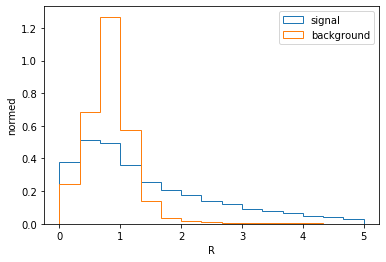

In [43]:
plt.hist(data_train_sig[issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='signal')
plt.hist(data_train_sig[~issignal].R,
         bins=15, range=(0,5), histtype='step', density=True, label='background')
plt.xlabel('R')
plt.ylabel('normed')
plt.legend()
plt.show()

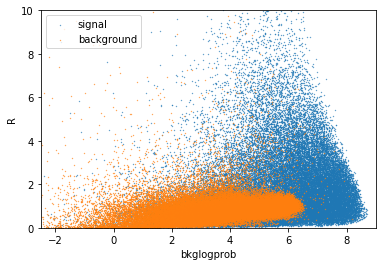

In [45]:
plt.scatter(data_train_sig[issignal].bkglogprob, data_train_sig[issignal].R, s=0.1, label='signal')
plt.scatter(data_train_sig[~issignal].bkglogprob, data_train_sig[~issignal].R, s=0.1, label='background')
plt.ylim(0,10)
plt.xlim(-2.5,9)
plt.xlabel('bkglogprob')
plt.ylabel('R')
plt.legend()
plt.show()

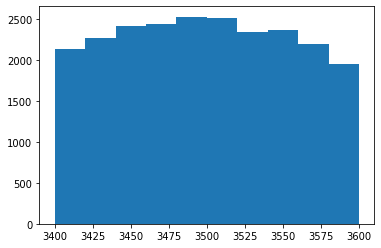

In [42]:
plt.hist(data_train_sig.query('R > 1.5').mJJ_unscaled)
plt.show()

In [71]:
nsamples=1000
#training_data_sampled=data_train_sig[:nsamples,:]
dist_sampled_data_bkg=bkgdist.sample(nsamples)
dist_sampled_data_sig=sigdist.sample(nsamples)

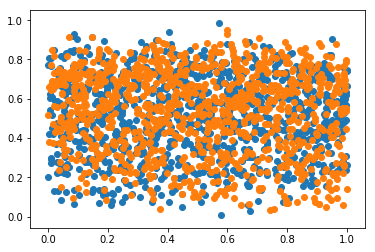

In [74]:
plt.scatter(dist_sampled_data_sig[:,0],dist_sampled_data_sig[:,2])
plt.scatter(dist_sampled_data_bkg[:,0],dist_sampled_data_bkg[:,2])

In [36]:
import corner
corner.corner(training_data_sampled)
plt.show()
corner.corner(dist_sampled_data_sig)
plt.show()

NameError: name 'training_data_sampled' is not defined